### Workflow Notebook

Here I returned to iterating with my GridSearch ElasticNet Model from Model 4, but I was finally able to establish a reproducible workflow where I could focus on making feature changes to the X and testset respectively and then running them, first on the train/test split to see the score on test, then on the 2000 houses including the holdout with the score on the training set, and finally adding to the testset file and submitting if I was happy with the results.  I made a number of models this way, only the most recent is shown here, but artifacts from the previous iterations are in the feature engineering section.


In [437]:
#Import all necessary packages and methods
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import patsy
import statsmodels.api as sm

from sklearn import metrics
from sklearn.metrics import r2_score, recall_score, make_scorer, f1_score, mean_squared_error

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV , RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression

from sklearn.preprocessing import StandardScaler, PolynomialFeatures #PowerTransformer

from sklearn.neighbors import KNeighborsRegressor


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.set_option('max_columns',300)

In [438]:
#Load cleaned X as csv.
X = pd.read_csv('../datasets/data_clean.csv')

In [439]:
#Removes the three extreme Price by Area outliers
X.drop(959,inplace=True)
X.drop(1882,inplace=True)
X.drop(125,inplace=True)


In [440]:
#Finalizes X and y for the train test split
y = X['SalePrice']
z = X['Id']
X.drop(['SalePrice','Id'], axis=1, inplace=True)

#####THESE NEED TO BE INCORPORATED BACK INTO CLEANING FILE AND NBVIEWER, SMH...
X.drop('Unnamed: 0', axis=1, inplace=True)
X.drop(['Roof Matl_CompShg','Roof Matl_Membran'],axis=1,inplace=True)

### Feature Engineering

This is where I made edits iteratively, on top of anything I had edited during the original data cleaning.

In [441]:
#This is where I made edits iteratively, on top of anything I had edited during the original data cleaning.
#Adding engineered features or polynomial features

X['Overall Qual Gr Liv Area'] = X['Overall Qual'] * X['Gr Liv Area']
X['Overall Qual^2'] = X['Overall Qual'] * X['Overall Qual']
X['Bathroom total'] = X['Full Bath'] + (0.5 * X['Half Bath'])

#Removes the 70 poorest correlated features (by absolute magnitude):
features_keep = list(abs(X.corrwith(y)).sort_values(ascending=False)[:-100].index)

X = X[features_keep]

X.drop(['Exterior 1st_CemntBd', 'Foundation_CBlock', 'Neighborhood_dummies_Timber', 'Alley', 'Electrical',
        'Lot Config_Inside', 'Neighborhood_dummies_BrDale', 'Exterior 2nd_HdBoard', 'Exterior 1st_MetalSd',
        'Neighborhood_dummies_NAmes', 'Neighborhood_dummies_BrkSide', 'House Style_2Story', 'MS SubClass_50','Roof Style_Hip',
        'Neighborhood_dummies_Sawyer', 'Mas Vnr Type_BrkFace','MS SubClass_60','Fence','Foundation_Slab','Exterior 2nd_CmentBd',
        'Bedroom AbvGr','Lot Shape','Exterior 2nd_MetalSd','Garage Type_BuiltIn','Garage Finish'], axis=1,inplace=True)

### Train Test Split and Holdout Set Creation / GridsearchCV with ElasticNet

In [444]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

param_grid_1 = {
    'alpha':[.1,.3,.5,.6,.7,.8,1,1.5],
    'l1_ratio':[0,.3,.5,.7,1]
}

gs_simple = GridSearchCV(ElasticNet(),param_grid_1,cv=5,verbose=1)

gs_simple.fit(X_train_sc,y_train_log)  

Fitting 5 folds for each of 40 candidates, totalling 200 fits


C:\Users\eamon\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\eamon\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\eamon\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\eamon\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\eamon\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\eamon\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\eamon\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\eamon\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 1, 1.5], 'l1_ratio': [0, 0.3, 0.5, 0.7, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [445]:
gs_simple.best_score_

0.9204739756942226

In [446]:
preds = gs_simple.predict(X_test_sc)

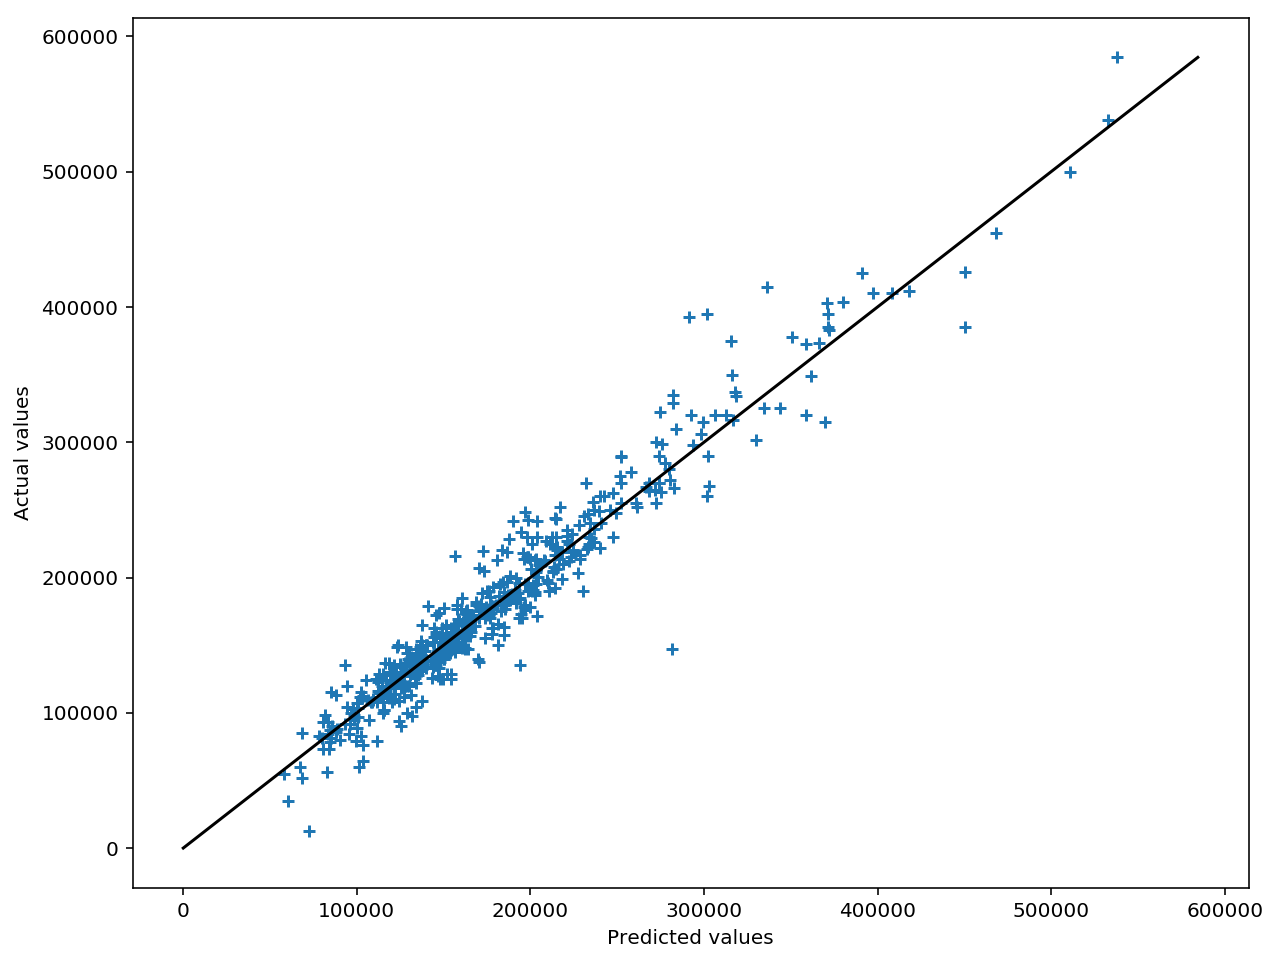

In [447]:
### Plots predicted values against actual values in the train/test split.
plt.figure(figsize=(10,8))
plt.scatter(np.exp(preds),y_test,marker = '+')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.plot([0,np.max(y_test)],[0,np.max(y_test)], c = 'k');

In [448]:
### Shows coefficients by variable
coefs = pd.DataFrame(gs_simple.best_estimator_.coef_,index=X_train.columns).sort_values(0)

In [449]:
coefs[abs(coefs[0])<.002]

,0
MS SubClass_190,-0.001139
Condition 2_PosN,-0.001122
Sale Type_WD,-0.000170
Open Porch SF,0.000457
Roof Style_Gable,0.000862
Condition 1_Feedr,0.000968
Bldg Type_2fmCon,0.001087


### Fit to full 2000 set of houses and see how it trains

In [450]:
model5 = gs_simple.best_estimator_

X_sc = ss.fit_transform(X)
y_log = np.log(y)

model5.fit(X_sc,y_log)

model5.score(X_sc,y_log)

C:\Users\eamon\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.923715841384795

### Apply to Testset for Kaggle Submission

In [451]:
testset = pd.read_csv('../datasets/test_clean.csv')

testset.drop('Id',axis=1,inplace=True)

testset.drop(['Roof Matl_Metal','Roof Matl_Roll'],axis=1,inplace=True)

###Changes to testset go here:

def changes_to_testset(X):
    X['Overall Qual Gr Liv Area'] = X['Overall Qual'] * X['Gr Liv Area']
    X['Overall Qual^2'] = X['Overall Qual'] * X['Overall Qual']
    X['Bathroom total'] = X['Full Bath'] + (0.5 * X['Half Bath'])
    
changes_to_testset(testset)

testset = testset[features_keep]

X.drop(['Exterior 1st_CemntBd', 'Foundation_CBlock', 'Neighborhood_dummies_Timber', 'Alley', 'Electrical',
        'Lot Config_Inside', 'Neighborhood_dummies_BrDale', 'Exterior 2nd_HdBoard', 'Exterior 1st_MetalSd',
        'Neighborhood_dummies_NAmes', 'Neighborhood_dummies_BrkSide', 'House Style_2Story', 'MS SubClass_50','Roof Style_Hip',
        'Neighborhood_dummies_Sawyer', 'Mas Vnr Type_BrkFace','MS SubClass_60','Fence','Foundation_Slab','Exterior 2nd_CmentBd',
        'Bedroom AbvGr','Lot Shape','Exterior 2nd_MetalSd','Garage Type_BuiltIn'], axis=1,inplace=True)

testset_sc = ss.transform(testset)

predictions = model5.predict(testset_sc)

predictions = np.exp(predictions)
predictions[0:10]

testset['SalePrice'] = predictions

testfile = pd.read_csv('../datasets/test_clean.csv') 
testset['Id'] = testfile['Id']

submission = testset[['Id','SalePrice']]

#Run when ready to submit
submission.to_csv('../datasets/ef_ames_12_6_ZB.csv',index=False)

In [ ]:
submission